   # Reinforcement Learning : PONG
    
Pierre Stefani (3202199)

## Mise en place de l'environnement et modèle principal

In [39]:
import gym
import torch
import numpy as np
import pickle as pkl
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from torch import nn

env = gym.make('Pong-v0') #charge l'environement
env.reset()  # reinitialiser le jeu
env.render() # afficher l'etat du jeu
env.action_space # liste des actions possibles
env.unwrapped.get_action_meanings() # signification des actions
observation, reward, done, info = env.step(1) # joue l'action 1
# et recoit l'observation (matrice) et le reward

## code de  http://karpathy.github.io/2016/05/31/rl/ pour
## preprocesser une image du jeu (scale down, monochrome)
def prepro(I):
  """ preprocessing 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

#code de http://karpathy.github.io/2016/05/31/rl/ 
def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, len(r))):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * 0.99 + r[t]
    discounted_r[t] = running_add
  return discounted_r

Le module principal est un Module pytorch implémentant un réseau de neurones simple:
    
    INPUT -- -- >  F1(linéaire) -- [RELU ACTIVATION] -- -- > F2(linéaire) -- [SOFTMAX] -- > OUTPUT
   
On le dote en plus de listes sauvegardant les actions choisies et les rewards récupérées pour notamment gérer le backward plus tard.
La dimension d'entrée est tirée du tutoriel de Karpathy, 80x80. Pour la sortie, on considère un tenseur de taille 2 (comme le choix parmi HAUT et BAS). On fera varier la dimension de la couche cachée afin d'évaluer les résultats

In [2]:
#module principal
class Model(nn.Module):
    
    def __init__(self,input_dim,h_dim,output_dim):
        super(Model, self).__init__()
        self.W1 = nn.Linear(input_dim,h_dim)
        self.relu = nn.ReLU()
        self.W2 = nn.Linear(h_dim,output_dim)
        
        self.actions = []
        self.rewards = []
        
    def forward(self,input):
        output = self.W1(input)
        output = self.relu(output)
        return F.softmax(self.W2(output))

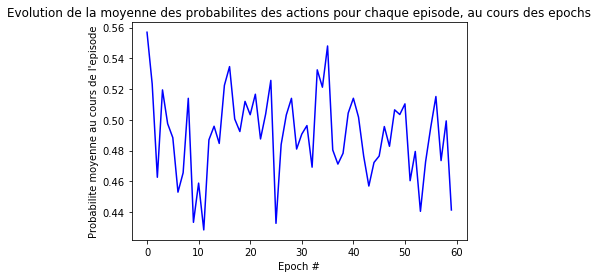

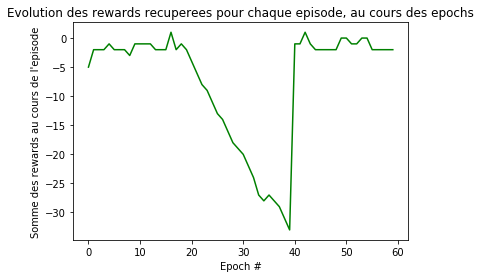

In [112]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(0)
plt.plot(mean_p,"-b")
plt.title("Evolution de la moyenne des probabilites des actions pour chaque episode, au cours des epochs")
plt.xlabel("Epoch #")
plt.ylabel("Probabilite moyenne au cours de l'episode")

plt.figure(1)
plt.plot(sum_r,"-g")
plt.title("Evolution des rewards recuperees pour chaque episode, au cours des epochs")
plt.xlabel("Epoch #")
plt.ylabel("Somme des rewards au cours de l'episode")

## Premier test du modèle

In [102]:
#dimension parameters : couche cachée, input (cf blog karpathy) et sortie (2 choix, haut ou bas)
dim_h = 200
input_dim = 80*80 
output_dim = 2

#model parameters : learning rate, discount factor, model et optimiseur
lr = 1e-2
df = 0.99
model = Model(input_dim,dim_h,output_dim)
optimizer = optim.SGD(model.parameters(), lr=lr)

#environment parameters : longueur de l'épisode, état initial, époques à considérer
T=200
s=env.reset()
max_epochs = 100

#local parameters : x_0 initial, arrays pour l'évolution des rewards et des probas
x_0 = np.zeros(input_dim)
sum_r = []
mean_p = []
dump = False

#### Apprentissage

In [104]:
for i in range(max_epochs):
    l = 0
    probas = []
    for t in range(T):   #episode
        #action
        x = prepro(s) - x_0 
        x_0 = x
        x = Variable(torch.FloatTensor(x))

        #passe avant et choix de l'action
        proba = model(x).view(1,-1)
        action = proba.multinomial()
        model.actions.append(action)
        tmp_proba = proba.view(-1)[action.data[0,0]].data[0] #for storing purposes
        probas.append(tmp_proba)
        l += tmp_proba

        #maj de l'environnement
        s,reward,done,info = env.step(2+action.data[0,0])
        model.rewards.append(reward)     
        #env.render()
        
        #si le jeu s'est terminé durant l'épisode: remise à zéro de l'environnement
        if done:
            s = env.reset()
            x_0 = np.zeros(input_dim)

    #episode fini, màj des éléments, backward, ...
    optimizer.zero_grad()
    rewards = torch.Tensor(discount_rewards(model.rewards))
    #normalisation des rewards : on se compare à la moyenne des rewards sur l'épisode
    if rewards.std()==0 : 
        rewards = (rewards - rewards.mean())
    else:
        rewards = (rewards - rewards.mean()) / rewards.std()
    #c'est la variable (-l * r) qui sera passée dans le backward
    for action, reward, proba_ in zip(model.actions,rewards,probas):
        action.reinforce(-proba_*reward)            #façon de faire torch 0_2.0_4 (?)
    torch.autograd.backward(model.actions, [None for _ in model.actions])   
    optimizer.step()
    
    if (i%5 == 0):
        print 'epoch' + str(i)
        #mise à jour des éléments stockant l'évolution des variables, reset éventuel de l'environnement, ..
        mean_p.append(np.mean(probas))
        sum_r.append(rewards.sum())
        
    del model.rewards[:]
    del model.actions[:]

if(dump):
    pkl.dump(model, open('pongmodel.p', 'wb'))
    #model = pkl.load(open('pongmodel.p', 'rb'))

epoch0
epoch5
epoch10
epoch15
epoch20
epoch25
epoch30
epoch35
epoch40
epoch45
epoch50
epoch55
epoch60
epoch65
epoch70
epoch75
epoch80
epoch85
epoch90
epoch95


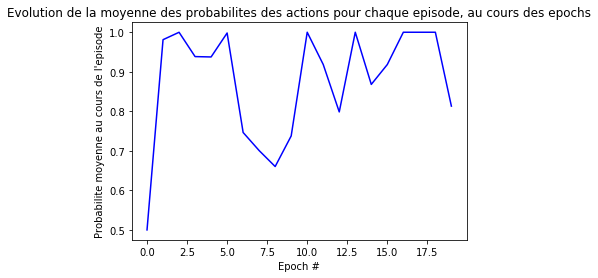

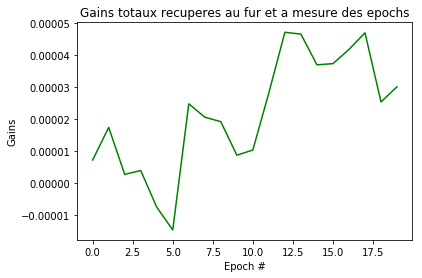

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(0)
plt.plot(mean_p,"-b")
plt.title("Evolution de la moyenne des probabilites des actions pour chaque episode, au cours des epochs")
plt.xlabel("Epoch #")
plt.ylabel("Probabilite moyenne au cours de l'episode")

plt.figure(1)
plt.plot(np.cumsum(sum_r),"-g")
plt.title("Gains totaux recuperes au fur et a mesure des epochs")
plt.xlabel("Epoch #")
plt.ylabel("Gains")

#### Pour jouer : 

In [108]:
done = False
s=env.reset()
x_0 = np.zeros(input_dim)
while not(done):
    x = prepro(s) - x_0 
    x_0 = x
    x = Variable(torch.FloatTensor(x))

    #passe avant et choix de l'action
    proba = model(x).view(1,-1)
    action = proba.multinomial()
    #maj de l'environnement
    s,reward,done,info = env.step(2+action.data[0,0])
    env.render()
    
env.close()

## Second test du modèle

On considère désormais un output de taille 3 pour ajouter une action: ne pas se déplacer.

In [158]:
#dimension parameters : couche cachée, input (cf blog karpathy) et sortie (2 choix, haut ou bas)
dim_h = 256
input_dim = 80*80 
output_dim = 3

#model parameters : learning rate, discount factor, model et optimiseur
lr = 1e-2
df = 0.99
model = Model(input_dim,dim_h,output_dim)
optimizer = optim.SGD(model.parameters(), lr=lr)

#environment parameters : longueur de l'épisode, état initial, époques à considérer
T=250
s=env.reset()
max_epochs = 100

#local parameters : x_0 initial, arrays pour l'évolution des rewards et des probas
x_0 = np.zeros(input_dim)
sum_r = []
mean_p = []
dump = False

In [159]:
for i in range(max_epochs):
    l = 0
    probas = []
    for t in range(T):   #episode
        #action
        x = prepro(s) - x_0 
        x_0 = x
        x = Variable(torch.FloatTensor(x))

        #passe avant et choix de l'action
        proba = model(x).view(1,-1)
        action = proba.multinomial()
        model.actions.append(action)
        tmp_proba = proba.view(-1)[action.data[0,0]].data[0] #for storing purposes
        probas.append(tmp_proba)
        l += tmp_proba

        #maj de l'environnement, que si l'action choisie est UP ou DOWN. La trosième action équivaut à rester en place
        if action.data[0,0] == 0:
            s,reward,done,info = env.step(action.data[0,0])
            model.rewards.append(reward)
        else:
            s,reward,done,info = env.step(1+action.data[0,0])
            model.rewards.append(reward)
        #env.render()
        
        #si le jeu s'est terminé durant l'épisode: remise à zéro de l'environnement
        if done:
            s = env.reset()
            x_0 = np.zeros(input_dim)

    #episode fini, màj des éléments, backward, ...
    optimizer.zero_grad()
    rewards = torch.Tensor(discount_rewards(model.rewards))
    #normalisation des rewards : on se compare à la moyenne des rewards sur l'épisode
    if rewards.std()==0 : 
        rewards = (rewards - rewards.mean())
    else:
        rewards = (rewards - rewards.mean()) / rewards.std()
    #c'est la variable (-l * r) qui sera passée dans le backward
    for action, reward, proba_ in zip(model.actions,rewards,probas):
        action.reinforce(-proba_*reward)    
    torch.autograd.backward(model.actions, [None for _ in model.actions])   
    optimizer.step()
    
    if (i%5 == 0):
        print 'epoch' + str(i)
        #mise à jour des éléments stockant l'évolution des variables, reset éventuel de l'environnement, ..
        mean_p.append(np.mean(probas))
        sum_r.append(rewards.sum())
        
    del model.rewards[:]
    del model.actions[:]

if(dump):
    pkl.dump(model, open('pongmodel.p', 'wb'))
    #model = pkl.load(open('pongmodel.p', 'rb'))

epoch0
epoch5
epoch10
epoch15
epoch20
epoch25
epoch30
epoch35
epoch40
epoch45
epoch50
epoch55
epoch60
epoch65
epoch70
epoch75
epoch80
epoch85
epoch90
epoch95


	 	 Avec output de taille 3 
 



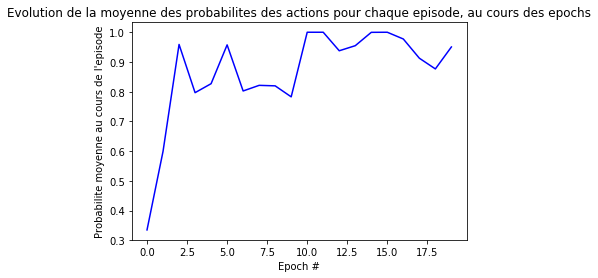

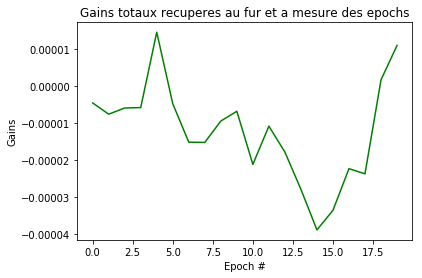

In [160]:
%matplotlib inline
import matplotlib.pyplot as plt
print "\t \t Avec output de taille 3 \n \n"
plt.figure(0)
plt.plot(mean_p,"-b")
plt.title("Evolution de la moyenne des probabilites des actions pour chaque episode, au cours des epochs")
plt.xlabel("Epoch #")
plt.ylabel("Probabilite moyenne au cours de l'episode")

plt.figure(1)
plt.plot(np.cumsum(sum_r),"-g")
plt.title("Gains totaux recuperes au fur et a mesure des epochs")
plt.xlabel("Epoch #")
plt.ylabel("Gains")

In [161]:
from collections import Counter
done = False
s=env.reset()
x_0 = np.zeros(input_dim)
actions = []
while not(done):
    x = prepro(s) - x_0 
    x_0 = x
    x = Variable(torch.FloatTensor(x))

    #passe avant et choix de l'action
    proba = model(x).view(1,-1)
    action = proba.multinomial()
    #maj de l'environnement
    if action.data[0,0] == 0:
        s,reward,done,info = env.step(action.data[0,0])
    else:
        s,reward,done,info = env.step(1+action.data[0,0])
    env.render()
    actions.append(action.data[0,0])
env.close() 
print Counter(actions)